# 추천 시스템 - 협업 필터링 Matrix Factorization

In [2]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [14]:
order_data = pd.read_csv('./dataset/preprocessing_orders.csv')
product_data = pd.read_csv('./dataset/preprocessing_product.csv')

In [15]:
order_data = order_data.drop('Unnamed: 0',axis=1)
order_data = order_data.drop('order_id', axis=1)
order_data

,order_date,product_id,member_id
0,2024-02-01 05:45:13.398265,87,7260
1,2024-01-28 19:50:16.218157,161,1340
2,2024-01-08 07:49:56.067986,86,392
3,2024-01-08 08:39:25.103003,277,5690
4,2024-02-19 01:30:09.341400,87,7823
...,...,...,...
9995,2024-01-29 15:28:21.989823,122,6586
9996,2024-02-15 06:11:18.692664,39,3001
9997,2024-02-13 10:06:34.004773,122,8738
9998,2024-01-07 14:46:59.073925,130,1446


In [16]:
product_data.head()

,Unnamed: 0,product_id,product_name,product_price,food_ingredient
0,0,1,[fresheasy] 나만의 심야식당 3종 세트,"26,800원","['기타가공품', '건마늘분말', '폴리인산나트륨', '복합조미식품', '치자적색소..."
1,1,2,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉 400g 1팩,"32,700원","['기타가공품', '복합조미식품', '식물성유지', '닭고기', '혼합제제', '정..."
2,2,3,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉 400g 3팩,"32,700원","['기타가공품', '복합조미식품', '식물성유지', '닭고기', '혼합제제', '정..."
3,3,4,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉400g 3팩,"21,900원","['기타가공품', '복합조미식품', '식물성유지', '닭고기', '혼합제제', '정..."
4,4,5,[fresheasy] 누구나홀딱반한닭 쉬림프치킨파히타 2인분 3팩,"53,700원","['기타 수산물가공품', '복합조미식품', '빵류', '청피망', '자연치즈', '..."


In [17]:
product_data = product_data.drop('Unnamed: 0',axis=1)
product_data = product_data.drop('product_price',axis=1)
product_data = product_data.drop('food_ingredient',axis=1)

product_data

,product_id,product_name
0,1,[fresheasy] 나만의 심야식당 3종 세트
1,2,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉 400g 1팩
2,3,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉 400g 3팩
3,4,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉400g 3팩
4,5,[fresheasy] 누구나홀딱반한닭 쉬림프치킨파히타 2인분 3팩
...,...,...
304,305,풀무원 전골 밀키트 4종(만두전골/어묵전골) 2개 골라담기
305,306,프레시지 사천식 마라탕 2인분
306,307,프레시지 우삼겹 마라 떡볶이 2인분
307,308,핑크퐁 아기상어 클레이 쿠키 만들기 250g x 2개


In [18]:
order_data.shape

(10000, 3)

In [19]:
product_data.shape

(309, 2)

## 전처리

In [20]:
order_product_data = pd.merge(order_data, product_data, on='product_id')
order_product_data.head()

,order_date,product_id,member_id,product_name
0,2024-02-01 05:45:13.398265,87,7260,[족발야시장] 족발야시장 직화 양념곱창 250g 6팩
1,2024-01-28 19:50:16.218157,161,1340,[프레시지] 한돈한우 남도떡갈비 200gx5팩(10개입)
2,2024-01-08 07:49:56.067986,86,392,[족발야시장] 족발야시장 직화 양념곱창 250g 3팩
3,2024-01-08 08:39:25.103003,277,5690,청정원 호밍스 밀키트 서울식 소불고기전골 650g x 2개
4,2024-02-19 01:30:09.341400,87,7823,[족발야시장] 족발야시장 직화 양념곱창 250g 6팩


In [21]:
order_product_data.shape

(10000, 4)

In [22]:
order_product_data

,order_date,product_id,member_id,product_name
0,2024-02-01 05:45:13.398265,87,7260,[족발야시장] 족발야시장 직화 양념곱창 250g 6팩
1,2024-01-28 19:50:16.218157,161,1340,[프레시지] 한돈한우 남도떡갈비 200gx5팩(10개입)
2,2024-01-08 07:49:56.067986,86,392,[족발야시장] 족발야시장 직화 양념곱창 250g 3팩
3,2024-01-08 08:39:25.103003,277,5690,청정원 호밍스 밀키트 서울식 소불고기전골 650g x 2개
4,2024-02-19 01:30:09.341400,87,7823,[족발야시장] 족발야시장 직화 양념곱창 250g 6팩
...,...,...,...,...
9995,2024-01-29 15:28:21.989823,122,6586,[지투지샵] 마이무 한입 양념 순살닭갈비 500g 3팩
9996,2024-02-15 06:11:18.692664,39,3001,[fresheasy] 최현석 밀키트 맛보기 5종 세트
9997,2024-02-13 10:06:34.004773,122,8738,[지투지샵] 마이무 한입 양념 순살닭갈비 500g 3팩
9998,2024-01-07 14:46:59.073925,130,1446,[프레시지] [선물세트] 한입LA갈비 500g X 3팩 + 한돈한우 남도떡갈비 20...


In [27]:
order_product_data.columns

Index(['order_date', 'product_id', 'member_id', 'product_name'], dtype='object')

In [34]:
order_product_data['purchased'] = 1

# pivot_table 생성
member_product = order_product_data.pivot_table(index='member_id', columns='product_name', values='purchased', fill_value=0)

# 결과 출력
member_product


product_name,10번 [모두의맛집] 오스테리아밀즈 한치먹물리조또,1번 [모두의맛집] 소문난 원조 조방낙지 낙곱새,3번 [본가스시] 제주 청귤 소바 (2인분),7번 [모두의맛집] 김씨육면 청돈육면,8번 [모두의맛집] 카레시 수프카레,CJ 비비고 돼지고기 김치찌개 460g x 3개,CJ 비비고 육개장 500g x 4개입,CJ 비비고 차돌 된장찌개 460g x 3개,[fresheasy] 나만의 심야식당 3종 세트,[fresheasy] 누구나홀딱반한닭 바사칸치킨윙봉 400g 1팩,...,풀무원 반듯한식 건강한 부대찌개 460g x 10봉,풀무원 반듯한식 건강한 부대찌개 460g x 5봉,풀무원 반듯한식 건강한 부대찌개 460g x 7봉,풀무원 쌀 국물떡볶이 423.5g(2인분) x 4봉,풀무원 우삼겹 어묵전골 밀키트 2종(버섯/등촌식) 2개 골라담기,풀무원 전골 밀키트 4종(만두전골/어묵전골) 2개 골라담기,프레시지 사천식 마라탕 2인분,프레시지 우삼겹 마라 떡볶이 2인분,핑크퐁 아기상어 클레이 쿠키 만들기 250g x 2개,핑크퐁 아기상어 클레이 쿠키 만들기 250g x 4개
member_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
product_member = member_product.values.T
product_member.shape

(304, 6293)

In [36]:
type(product_member)

numpy.ndarray

## SVD(Singular Value Decomposion)

In [37]:
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(product_member)
matrix.shape

(304, 12)

In [38]:
matrix[0]

array([ 0.04410647,  0.13704338,  0.1697267 , -0.06982469, -0.26190622,
       -0.1200739 ,  0.06833169, -0.20495686,  0.10117495,  0.19549806,
       -0.18332885, -0.13274446])

In [39]:
corr = np.corrcoef(matrix)
corr.shape

(304, 304)

In [40]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

<Axes: >

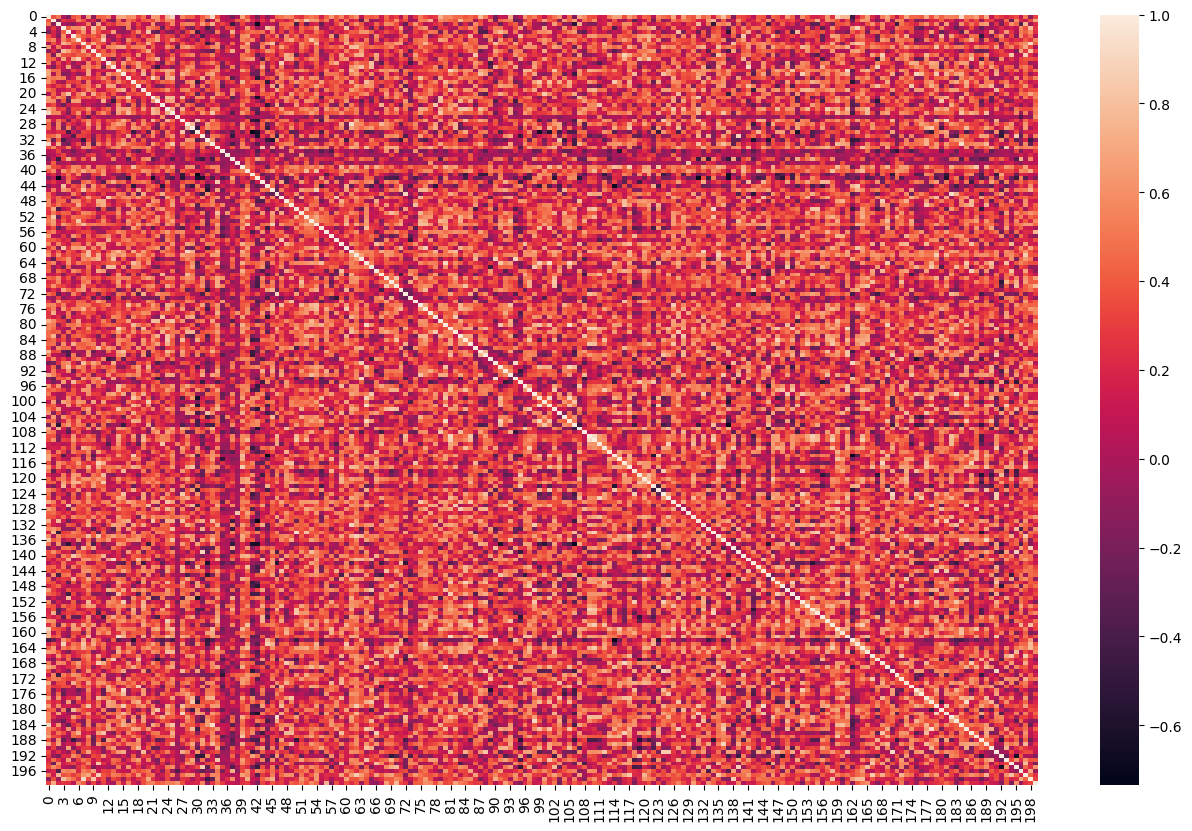

In [41]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

In [44]:
product_name = member_product.columns
product_name_list = list(product_name)
coffey_hands = product_name_list.index('10번 [모두의맛집] 오스테리아밀즈 한치먹물리조또')

In [45]:
corr_coffey_hands  = corr[coffey_hands]
list(product_name[(corr_coffey_hands >= 0.9)])[:50]

['10번 [모두의맛집] 오스테리아밀즈 한치먹물리조또',
 '[fresheasy] 우리쌀밥 즉석밥 백미 210g 1BOX (36개입)',
 '[fresheasy] 젠틀플레이트 비법양념주꾸미 300g 3팩',
 '당일 제조하여 더욱 신선한 쿡솜씨 대구뽈탕']

## 한 사용자에게 개인 추천을 해주기

위에서는 하나의 영화에 대해서 비슷한 영화를 추천해주는 것을 적용   
보통 추천 시스템은 사용자에게 추천을 해주어야 

아래부터는 사용자에게 추천을 해주기 위해서 사용자 맞춤 협업 필터링 행렬 분해를 적용

In [93]:
df_order = pd.read_csv('./dataset/preprocessing_orders.csv')
df_product = pd.read_csv('./dataset/preprocessing_product.csv')

In [94]:
df_order['purchased'] = 1

In [96]:
df_order

,Unnamed: 0,order_id,order_date,product_id,member_id,purchased
0,0,1,2024-02-01 05:45:13.398265,87,7260,1
1,1,2,2024-01-28 19:50:16.218157,161,1340,1
2,2,3,2024-01-08 07:49:56.067986,86,392,1
3,3,4,2024-01-08 08:39:25.103003,277,5690,1
4,4,5,2024-02-19 01:30:09.341400,87,7823,1
...,...,...,...,...,...,...
9995,9995,9996,2024-01-29 15:28:21.989823,122,6586,1
9996,9996,9997,2024-02-15 06:11:18.692664,39,3001,1
9997,9997,9998,2024-02-13 10:06:34.004773,122,8738,1
9998,9998,9999,2024-01-07 14:46:59.073925,130,1446,1


In [56]:
# df_member_product = df_order.pivot(index='member_id', columns='product_id', values='purchased').fillna(0)
df_member_product = df_order.pivot_table(index='member_id', columns='product_id', values='purchased', aggfunc='sum').fillna(0)

In [97]:
df_member_product.head(9)

product_id,1,2,3,4,5,6,7,8,9,10,...,300,301,302,303,304,305,306,307,308,309
member_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
matrix = df_member_product.values  # 구매 여부 데이터를 numpy 배열로 변환

# member_purchased_mean은 사용자의 평균 구매 여부 
member_purchased_mean = np.mean(matrix, axis=1)

# R_member_mean : 사용자-상품에 대해 사용자 평균 구매 여부를 뺀 것.
matrix_member_mean = matrix - member_purchased_mean.reshape(-1, 1)

In [64]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
matrix.shape

(6293, 309)

In [66]:
member_purchased_mean.shape

(6293,)

In [67]:
matrix_member_mean.shape

(6293, 309)

In [69]:
pd.DataFrame(matrix_member_mean, columns=df_member_product.columns).head()

product_id,1,2,3,4,5,6,7,8,9,10,...,300,301,302,303,304,305,306,307,308,309
0,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,...,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472
1,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,...,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,-0.012945,0.987055,-0.012945,-0.012945,-0.012945
2,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,...,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,0.993528,-0.006472
3,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,...,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236,-0.003236
4,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,...,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472,-0.006472


In [70]:
U, sigma, Vt = svds(matrix_member_mean, k = 12)

In [71]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(6293, 12)
(12,)
(12, 309)


In [72]:
sigma = np.diag(sigma)

In [73]:
sigma.shape

(12, 12)

In [74]:
sigma[0]

array([6.94144461, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [75]:
sigma[1]

array([0.        , 6.94455921, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [76]:
svd_member_predicted_order = np.dot(np.dot(U, sigma), Vt) + member_purchased_mean.reshape(-1, 1)

In [77]:
df_svd_preds = pd.DataFrame(svd_member_predicted_order, columns = df_member_product.columns)
df_svd_preds.head()

product_id,1,2,3,4,5,6,7,8,9,10,...,300,301,302,303,304,305,306,307,308,309
0,-0.003444,0.009103,0.023911,-0.006281,0.002414,0.002312,0.000839,0.039055,0.000967,-0.014695,...,-0.031563,0.011435,-0.063796,0.005232,-0.003390,-0.001352,0.007014,0.013401,0.010863,0.006371
1,0.023366,0.009086,-0.009748,0.010035,0.006526,0.004701,-0.010073,-0.045853,0.014316,0.018763,...,0.048594,0.024268,-0.000069,0.013750,-0.007502,0.038552,0.212947,0.027995,0.004269,-0.002159
2,0.007255,0.009285,0.005498,0.008457,0.006182,0.006919,0.013452,0.011052,0.004551,0.005920,...,0.005032,0.002286,0.024289,0.006475,0.011013,0.007611,-0.007730,0.005675,0.015241,0.008978
3,0.015578,0.001751,0.004700,0.000957,0.008564,-0.005964,0.000869,-0.023441,0.000585,0.015131,...,0.014532,0.008103,0.034802,0.002475,-0.006796,-0.003228,0.023348,0.006117,0.003624,0.000654
4,0.000670,0.000533,0.011388,0.003058,0.005428,-0.005989,0.003249,-0.014786,0.006909,0.004092,...,0.028402,0.008182,-0.003938,0.008509,0.011062,0.027290,0.015134,0.001040,0.006094,0.006581


In [78]:
df_svd_preds.shape

(6293, 309)

In [91]:
df_order

,Unnamed: 0,order_id,order_date,product_id,member_id,purchased
0,0,1,2024-02-01 05:45:13.398265,87,7260,1
1,1,2,2024-01-28 19:50:16.218157,161,1340,1
2,2,3,2024-01-08 07:49:56.067986,86,392,1
3,3,4,2024-01-08 08:39:25.103003,277,5690,1
4,4,5,2024-02-19 01:30:09.341400,87,7823,1
...,...,...,...,...,...,...
9995,9995,9996,2024-01-29 15:28:21.989823,122,6586,1
9996,9996,9997,2024-02-15 06:11:18.692664,39,3001,1
9997,9997,9998,2024-02-13 10:06:34.004773,122,8738,1
9998,9998,9999,2024-01-07 14:46:59.073925,130,1446,1


In [98]:
def recommend_products(df_svd_preds, member_id, ori_product_df, ori_ratings_df, num_recommendations=5):
    member_row_number = member_id - 1
    sorted_member_predictions = df_svd_preds.iloc[member_row_number].sort_values(ascending=False)
    member_data = ori_ratings_df[ori_ratings_df.member_id == member_id]
    member_history = member_data.merge(ori_product_df, on = 'product_id').sort_values(['purchased'], ascending=False)
    recommendations = ori_product_df[~ori_product_df['product_id'].isin(member_history['product_id'])]
    recommendations = recommendations.merge( pd.DataFrame(sorted_member_predictions).reset_index(), on = 'product_id')
    recommendations = recommendations.rename(columns = {member_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
    return member_history, recommendations

In [99]:
already_rated, predictions = recommend_products(df_svd_preds, 6586, df_product, df_order, 10)

IndexError: single positional indexer is out-of-bounds

In [ ]:
already_rated

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15026335309886627560
 xla_global_id: -1]

In [2]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 30.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 40.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.7 MB/s eta 0:00:0031m47.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 43.9 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.1 MB/s eta 0:00

In [5]:
import torch

In [6]:
torch.cuda.is_available()

False

In [7]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled